In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from qutip import *
import math
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import pickle
from matplotlib.lines import Line2D
from ipywidgets import interact, SelectionSlider, Layout
from scipy.signal import hilbert

from matplotlib import rc
plt.rc('font',**{'family':'serif','sans-serif':['Computer Modern Sans serif'],'size':16})
plt.rcParams['text.usetex'] = True

In [2]:
func = lambda x, dr : np.exp(-dr*x)

func1 = lambda x, dr : 1.5*np.exp(-dr*x)

#To load dictionary from text file
def LoadDictionary(File):
    with open(File, "rb") as myFile:
        dict = pickle.load(myFile)
        myFile.close()
        return dict

In [ ]:
nst = 1

# The files here are same as the ones in AnalysedData folder
t = LoadDictionary(f"data/Time_{nst}1.txt")
Navg = LoadDictionary(f"data/Navg_{nst}1.txt")
rho = LoadDictionary(f"data/Rho_{nst}1.txt")
fid = LoadDictionary(f"data/Fidelity_{nst}1.txt")
err = LoadDictionary(f"data/Error_{nst}1.txt")

geff = 1*1.5*np.pi*8.56*1.e6/(np.sqrt(100)*7000*1.e7)

# Distance parameters needed for finding peaks in the fidelity and Navg data
sigma = [[1475, 1390, 1000, 700, 550, 425, 340, 260, 198, 154, 115], [1440, 1400,  900, 600, 459, 410, 325, 260, 197, 153, 114], [1870, 1850,  962, 817, 492, 279, 256, 230, 149, 139, 115]]

In [4]:
dRtF = {}
dRtN = {}
x0N = {}
NErr = {}

wc = 7000*1.e7      #Cavity frequency
g  = 0.000576258    #Coupling

s = 0
for sig in [10, 30, 60]:
    rr = 0
    for r in [0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5]:
        for st in [1]:
                scale = (4)/(2*np.pi)
                key = (r,sig,st)
                t[key] *= scale

                if r==0.0 and st==0:
                    dRtF[key] = 0
                    dRtN[key] = 0

                else:
                    nrabi = 2
                    dst = sigma[s][rr]
                    x, y = t[key][:len(t[key])//nrabi], fid[key][:len(t[key])//nrabi]
                    idx, _ = find_peaks(y, distance=dst)
                    idx[0] = 0
                    x = x[idx]
                    y = y[idx]
                    popt, pcov = curve_fit(func, x, y)
                    dRtF[key] = popt[0]

                    x, y = t[key][:len(t[key])//nrabi], Navg[key][:len(t[key])//nrabi]
                    idx, _ = find_peaks(y, distance=dst)
                    idx = [0] + list(idx)
                    x = x[idx]
                    y = y[idx]
                    popt, pcov = curve_fit(func1, x, y)
                    dRtN[key] = popt[0]
                    err = np.sqrt(np.diag(pcov))
                    
                    # ynew = func1(x,popt[0])
                    # err = np.sqrt(np.average((np.array(y)-np.array(ynew))**2))
                    
                    NErr[key] = err[0]
        print(r, sig, st, f', Fidelity = {dRtF[key]}, \tNavg = {dRtN[key]}, \tstd = {err}')
        rr += 1
    s += 1

0.0 10 1 , Fidelity = 0.7370746889541692, 	Navg = 1.6891039576895015, 	std = [0.09436709]
0.25 10 1 , Fidelity = 0.6200936346863993, 	Navg = 1.4252664972625377, 	std = [0.10793878]
0.5 10 1 , Fidelity = 0.47849394347390456, 	Navg = 1.0222524374117539, 	std = [0.07439441]
0.75 10 1 , Fidelity = 0.42853011794948287, 	Navg = 0.8528272421704927, 	std = [0.04483264]
1.0 10 1 , Fidelity = 0.4160871545461915, 	Navg = 0.811278546219725, 	std = [0.02780999]
1.25 10 1 , Fidelity = 0.41084249301344566, 	Navg = 0.792542615209726, 	std = [0.01897075]
1.5 10 1 , Fidelity = 0.4051442096613164, 	Navg = 0.7820635807193802, 	std = [0.01372995]
1.75 10 1 , Fidelity = 0.4013965848535495, 	Navg = 0.7739755574878568, 	std = [0.00976027]
2.0 10 1 , Fidelity = 0.41131673293555804, 	Navg = 0.762803556706565, 	std = [0.00658632]
2.25 10 1 , Fidelity = 0.44442883561826524, 	Navg = 0.7159996408781337, 	std = [0.00423962]
2.5 10 1 , Fidelity = 0.8293378771629439, 	Navg = 0.4511697531413644, 	std = [0.07436282]
0.0

In [5]:
def plot_data(r,sig,st,fdst):
    key = (r, sig, st)
    color = ['red','green','blue','black']
    style = ['solid','dashed','dot-dashed']
    labels = [f'For State $|\\psi\\rangle =  \\sqrt{{1/2}} |{st}\\rangle + \\sqrt{{1/2}} |{st+1}\\rangle$']
    nrabi = 2
    fig,(ax0, ax1) = plt.subplots(nrows=1,ncols=2,figsize=(12, 5), layout='constrained', facecolor='0.99')

    x, y = t[key][:len(t[key])//nrabi], fid[key][:len(t[key])//nrabi]
    idx, _ = find_peaks(y,distance=fdst)
    idx[0] = 0
    x = x[idx]
    y = y[idx]
    popt, pcov = curve_fit(func, x, y)

    ax0.plot(t[key], fid[key])
    ax0.plot(t[key],func(t[key],popt[0]),label=f'decay rt = {np.round(popt[0],4)}')
    ax0.scatter(x,y,color='black')
    ax0.set_xlabel(r'Time',fontsize=15,labelpad=2)
    ax0.set_ylabel(r'Fidelity $\mathcal{F}$',fontsize=15,labelpad=2)
    #ax0.set_xlim((0,6))
    ax0.set_ylim((0,1))
    ax0.grid()
    ax0.legend()

    x, y = t[key][:len(t[key])//nrabi], Navg[key][:len(t[key])//nrabi]
    idx, _ = find_peaks(y,distance=fdst)
    idx = [0] + list(idx)
    x = x[idx]
    y = y[idx]
    popt, pcov = curve_fit(func1, x, y)

    ax1.plot(t[key], Navg[key])
    ax1.plot(t[key],func1(t[key],dRtN[key]),label=f'decay rt = {np.round(popt[0],4)}')
    ax1.scatter(x,y,color='black')
    ax1.set_xlabel(r'Time',fontsize=15,labelpad=2)
    ax1.set_ylabel(r'Average no of photons $\langle \hat{n} \rangle$',fontsize=15,labelpad=2)
    #ax1.set_xlim((0,6))
    ax1.set_ylim((0,2.0))
    ax1.grid()
    ax1.legend()
    plt.suptitle(labels[0],fontsize=15)
    plt.show()

# Define specific values for frequency and amplitude
rvals = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5]
sigval = [10,30,60]
stval = [1]
dist = np.linspace(1,20000,20000)
# Create selection sliders for specific frequency and amplitude values
interact(
    plot_data,
    r=SelectionSlider(options=rvals, value=1.75, description='r',layout=Layout(width='300px')),
    sig=SelectionSlider(options=sigval, value=30, description='wid',layout=Layout(width='300px')),
    st=SelectionSlider(options=stval, value=1, description='N',layout=Layout(width='300px')),
    fdst=SelectionSlider(options=dist, value=260, description='Fdst',layout=Layout(width='300px'))
)

interactive(children=(SelectionSlider(description='r', index=7, layout=Layout(width='300px'), options=(0.0, 0.…

<function __main__.plot_data(r, sig, st, fdst)>

In [6]:
xvec = np.linspace(-2,2,600)
pos = 279

d0 = rho[(0.0,30,1)][0]
W0 = wigner(d0, xvec, xvec)

d1 = rho[(0.0,30,1)][1604]
W1 = wigner(d1, xvec, xvec)

d3 = rho[(1.75,30,1)][541]
W3 = wigner(d3, xvec, xvec)

d4 = rho[(2.0,60,1)][541]
W4 = wigner(d4, xvec, xvec)

In [7]:
def spectral_density(Om,std):
    coeff = np.sqrt(np.log(2)/np.pi)/std
    exp   = np.exp(-1*(Om**2)*np.log(2)/(std**2))
    return (coeff*exp)

fontsize = 18
wc = 7000*1.e7      #Cavity frequency
ka = 7           #Cavity decay rate
gp = ka/16          #deoherence rate
gh = ka/8           #decay rate
g  = 40#0.000576258    #Coupling

xdata = np.linspace(0,2.5,101)
dataXX = 40*np.exp(xdata)/2*(1/(2*np.pi))
finaldat = []; rfinaldat = []
for std in [60, 30, 10]:
    std = std#*1E6/wc
    data = []; rdata = []
    for r in xdata:
        geff = g*np.cosh(r)

        rho_om = spectral_density(geff,std)

        Gamma = ((ka + 2*gp + gh) + np.pi*rho_om*(geff**2))
        ratio = np.pi*rho_om*(geff**2)/(ka + 2*gp + gh)
        data.append(Gamma*2*np.pi/g)
        rdata.append(ratio)
    finaldat.append(data)
    rfinaldat.append(rdata)

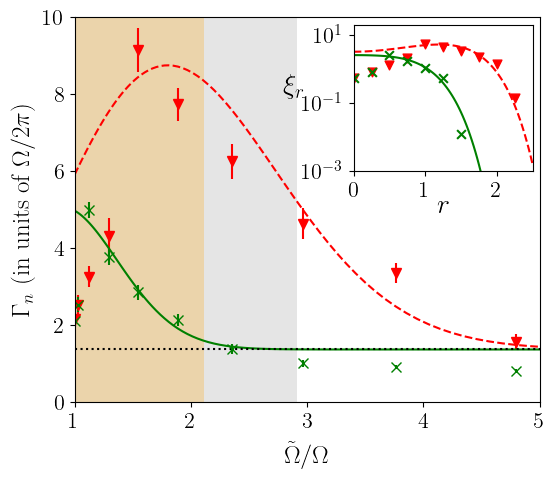

In [8]:
color = ['red','green','blue']
style = ['dashed','solid','dashdot']
marker = ['v','x','^']
size = [40,40,40]
size1 = [7,7,7]

fig,(ax0) = plt.subplots(1,1,gridspec_kw={'hspace':0.1,'wspace':0.35},\
                                          figsize=(6,5),sharex=True)#,subplot_kw=dict(box_aspect=1))

label0 = [r'$\delta$ = 10 MHz',r'$\delta$ = 30 MHz',r'$\delta$ = 60 MHz']

rr = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25]
rr = np.array(rr)
den = 1.25*ka*2*np.pi/(g)
                        
ids = 0
rfinaldatOrg = []
for sig in [60,30]:
    dataX = []; dataN = []; dataF = []; dataNer = [];
    for r in rr:
        key = (r,sig,1)
        dataF.append(dRtF[key])
        dataN.append(dRtN[key])
        dataNer.append(NErr[key])
        dataX.append(np.cosh(r))
    
    dataX,dataN = np.array(dataX),np.array(dataN)
    rfinaldatOrg.append((dataN/den)-1)

    ax0.plot(np.cosh(xdata),finaldat[ids],linestyle=style[ids],c=color[ids],label=label0[ids])
    ax0.errorbar(dataX,dataN,yerr = dataNer, fmt = marker[ids],markersize=size1[ids],c=color[ids])
    
    ids += 1

axins = ax0.inset_axes(
   [0.6, 0.6, 0.385, 0.38],
   xlim=(0,2.5), ylim=(1E-3, 20))

ids = 0
for sig in [60, 30, 10]:
    axins.semilogy(xdata,rfinaldat[ids],linestyle=style[ids],c=color[ids],label=label0[ids])
    if sig ==30 or sig==60:
        axins.scatter(rr,(rfinaldatOrg[ids]),marker=marker[ids],s=size[ids],c=color[ids])
    ids+=1

axins.set_ylabel(r'$\xi_r$',rotation='horizontal',labelpad=7,fontsize=20)
axins.set_xlabel(r'$r$',labelpad= -5,fontsize=20)
axins.set_xticks([0, 1, 2])

ax0.plot(np.cosh(xdata),1.25*ka*2*np.pi/g*np.ones(len(xdata)),color = 'black', linestyle='dotted')
ax0.set_xlabel(r'$\tilde{\Omega}/\Omega$',labelpad=6,fontsize=18)
ax0.set_ylabel(r'$\Gamma_{{n}}$ (in units of ${\Omega}/2\pi$)',labelpad=6,fontsize=18)
ax0.fill_betweenx(range(17), 0,np.cosh(1.73), alpha=0.2, facecolor='gray')
ax0.fill_betweenx(range(17), 0,np.cosh(1.38), alpha=0.25, facecolor='orange')
ax0.set_xlim((1,5))
ax0.set_ylim((0,10))

ax0.tick_params(axis='both', which='major', labelsize=16)
axins.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('Fig3.pdf',bbox_inches='tight',dpi=600)
plt.show()


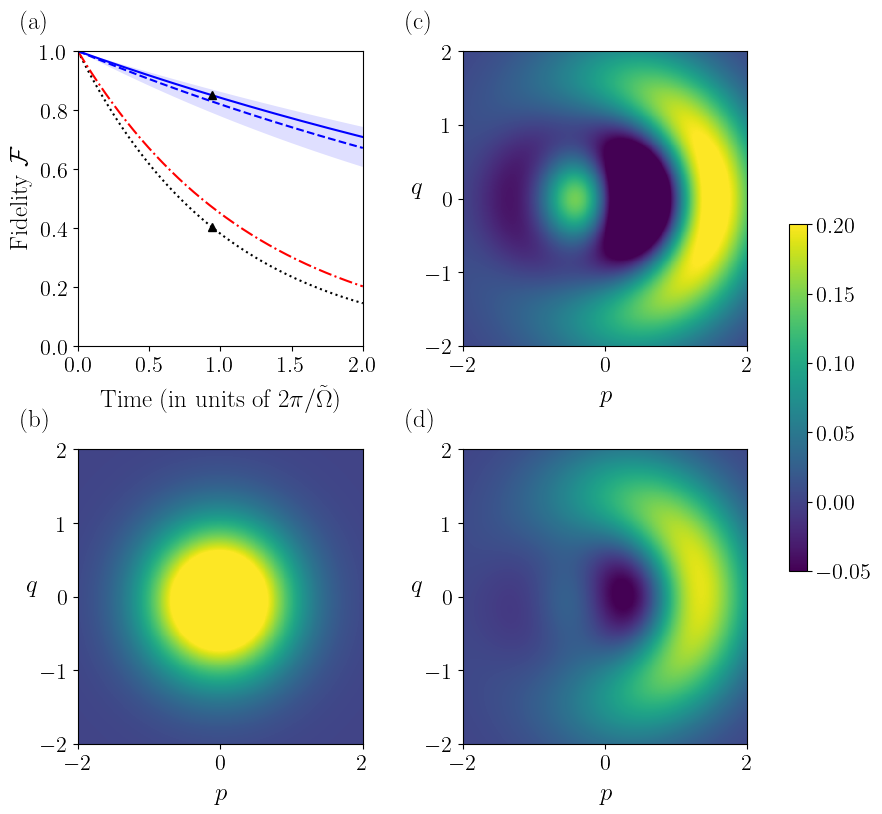

In [9]:
fig1,((ax1,ax2),(ax3,ax5)) = plt.subplots(2,2,gridspec_kw={'hspace':0.35,'wspace':0.35},\
                                          figsize=(10.8,9))#,subplot_kw=dict(box_aspect=1))

ax1.set_xlabel(r'Time (in units of $\kappa^{-1}$)',labelpad=6,fontsize=fontsize)
ax1.set_ylabel(r'Fidelity $\mathcal{F}$',labelpad=6,fontsize=fontsize)

ax2.set_xlabel(r'$p$',labelpad=6,fontsize=fontsize)
ax3.set_xlabel(r'$p$',labelpad=6,fontsize=fontsize)
ax5.set_xlabel(r'$p$',labelpad=6,fontsize=fontsize)

ax2.set_ylabel(r'$q$',labelpad=6,fontsize=fontsize,rotation=0)
ax3.set_ylabel(r'$q$',labelpad=6,fontsize=fontsize,rotation=0)
ax5.set_ylabel(r'$q$',labelpad=6,fontsize=fontsize,rotation=0)

cmap = plt.get_cmap('gnuplot')
colors = ['black', 'red', 'blue']
rrr = [0.0, 1.0, 1.75]
style = ['dotted','dashdot','solid']
tf = 2
tt = np.linspace(0,tf,1000)
idx=0

dRt = 0.1989732580798083; dRtpm = 0.050461706907399644 #Data extracted from average over 584 states
for r in rrr:
    key = (r,30,1)
    dRtt = dRtF[key]/np.cosh(r)
    ax1.plot(tt,func(tt,dRtt),linestyle=style[idx],color=colors[idx], label = f'$r$ = {r}')
    
    if r == 0.0 or r == 1.75:
        ax1.plot(0.94,func(0.94,dRtt),' ^', c='black')
    
    if r == 1.75:
        ax1.plot(tt,func(tt,dRt),linestyle='dashed',color=colors[2])
        ax1.fill_between(tt,func(tt,dRt-dRtpm),func(tt,dRt+dRtpm), facecolor='blue', alpha=0.125)
    idx+=1

ax1.set_xlabel(r'Time (in units of $2\pi/\tilde{\Omega}$)',labelpad=6,fontsize=fontsize)
ax1.set_ylabel(r'Fidelity $\mathcal{F}$',labelpad=6,fontsize=fontsize)
ax1.set_xlim((0,tf))
ax1.set_ylim((0,1))

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax5.tick_params(axis='both', which='major', labelsize=16)

im2 = ax2.pcolor(xvec,xvec,W0,vmin=-0.05,vmax=0.2)

im3 = ax3.pcolor(xvec,xvec,W1,vmin=-0.05,vmax=0.2)

im5 = ax5.pcolor(xvec,xvec,W3,vmin=-0.05,vmax=0.2)

cb=fig1.colorbar(im2,ax=[ax2,ax5,ax1,ax3],shrink=0.5)
cb.ax.tick_params(labelsize=16)

f1 = 11.5
ax1.text(-0.4, 1.1, "(a)", va='center',fontsize=fontsize)
ax2.text(-2.8, 2.4, "(c)", va='center',fontsize=fontsize)
ax3.text(-2.8, 2.4, "(b)", va='center',fontsize=fontsize)
ax5.text(-2.8, 2.4, "(d)", va='center',fontsize=fontsize)

plt.savefig('Fig4.png',bbox_inches='tight',dpi=300)
plt.show()